In [1]:
import gym
import ray
from gym.spaces import Discrete, Tuple
from ray import tune
from ray.rllib.agents.ppo import PPOTrainer
from ray.rllib.models import ModelCatalog, ModelV2
from ray.rllib.models.tf.misc import normc_initializer
from ray.rllib.models.utils import get_filter_config
from ray.rllib.utils import override
from scouting_gym.tasks.scouting_discrete_task import ScoutingDiscreteTask
import matplotlib.pyplot as plt
import numpy as np

Instructions for updating:
non-resource variables are not supported in the long term
None


In [2]:
env = gym.make('Scouting-v0')

print(env.observation_space)

[ERROR] [1611907619.790632, 175.666000]: NOT Initialising Simulation Physics Parameters
[WARN] [1611907619.796088, 0.009000]: Start Init ControllersConnection
[WARN] [1611907619.797393, 0.009000]: END Init ControllersConnection


Tuple(Box(0.0, 4.0, (18,), float32), Box(-10.0, 10.0, (2,), float32), Box(-1.0, 1.0, (2,), float32))


In [3]:
obs = env.reset()
obs[2]

array([-1.,  1.])

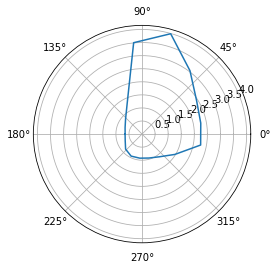

In [6]:
obs = env.reset()
plt.figure()
thetas = np.linspace(-2.44, 2.44, 18)
thetas = np.linspace(-3.14, 3.14, 18)
plt.polar(thetas, obs[0])
plt.show()


In [4]:
env.reset()
for _ in range(40):
    #obs, reward, done, _ = env.step(1)
    obs, reward, done, _ = env.step([0.6, ])
print(obs[0].min())
print(obs[0].max())

#plt.imshow(obs[0].squeeze())

0.6978138
3.99


In [5]:
#print(obs)


In [3]:
import tensorflow as tf
from ray.rllib.models.tf.tf_modelv2 import TFModelV2

class CNNPlusFCConcatModel(TFModelV2):
    """TFModelV2 concat'ing CNN outputs to flat input(s), followed by FC(s).

    Note: This model should be used for complex (Dict or Tuple) observation
    spaces that have one or more image components.
    """

    def __init__(self, obs_space, action_space, num_outputs, model_config,
                 name):
        # TODO: (sven) Support Dicts as well.
        assert isinstance(obs_space.original_space, (Tuple)), \
            "`obs_space.original_space` must be Tuple!"

        super().__init__(obs_space, action_space, num_outputs, model_config,
                         name)

        # Build the CNN(s) given obs_space's image components.
        self.cnns = {}
        concat_size = 0
        for i, component in enumerate(obs_space.original_space):
            # Image space.
            if len(component.shape) == 3:
                config = {
                    "conv_filters": [[16, [3, 3], 2], [32, [3, 3], 2], [64, [3, 3], 2], [128, [5, 16], 1]],
                    "conv_activation": model_config.get("conv_activation"),
                }
                cnn = ModelCatalog.get_model_v2(
                    component,
                    action_space,
                    num_outputs=None,
                    model_config=config,
                    framework="tf",
                    name="cnn_{}".format(i))
                concat_size += cnn.num_outputs
                self.cnns[i] = cnn
                self.register_variables(cnn.base_model.variables)
            # Discrete inputs -> One-hot encode.
            elif isinstance(component, Discrete):
                concat_size += component.n
            # TODO: (sven) Multidiscrete (see e.g. our auto-LSTM wrappers).
            # Everything else (1D Box).
            else:
                assert len(component.shape) == 1, \
                    "Only input Box 1D or 3D spaces allowed!"
                concat_size += component.shape[-1]

        self.logits_and_value_model = None
        self._value_out = None
        if num_outputs:
            # Action-distribution head.
            concat_layer = tf.keras.layers.Input((concat_size, ))
            logits_layer = tf.keras.layers.Dense(
                num_outputs,
                activation=tf.keras.activations.linear,
                name="logits")(concat_layer)

            # Create the value branch model.
            value_layer = tf.keras.layers.Dense(
                1,
                name="value_out",
                activation=None,
                kernel_initializer=normc_initializer(0.01))(concat_layer)
            self.logits_and_value_model = tf.keras.models.Model(
                concat_layer, [logits_layer, value_layer])
        else:
            self.num_outputs = concat_size
        self.register_variables(self.logits_and_value_model.variables)

    @override(ModelV2)
    def forward(self, input_dict, state, seq_lens):
        # Push image observations through our CNNs.
        outs = []
        for i, component in enumerate(input_dict["obs"]):
            if i in self.cnns:
                cnn_out, _ = self.cnns[i]({"obs": component})
                outs.append(cnn_out)
            else:
                outs.append(component)
        # Concat all outputs and the non-image inputs.
        out = tf.concat(outs, axis=1)
        if not self.logits_and_value_model:
            return out, []

        # Value branch.
        logits, values = self.logits_and_value_model(out)
        self._value_out = tf.reshape(values, [-1])
        return logits, []

    @override(ModelV2)
    def value_function(self):
        return self._value_out

ModelCatalog.register_custom_model("CNNPlusFCConcatModel", CNNPlusFCConcatModel)

config = {
    "env": ScoutingDiscreteTask,  # or "corridor" if registered above
    "env_config": {
        "corridor_length": 5,
    },
    # Use GPUs iff `RLLIB_NUM_GPUS` env var set to > 0.

    "num_gpus": 1,
    "num_workers": 1,  # parallelism
    "model": {
        #"custom_model": "CNNPlusFCConcatModel",
        #"conv_filters": [[16, [4, 3], 2], [32, [3, 3], 2], [64, [3, 3], 2], [128, [5, 16], 1]],
        "fcnet_hiddens": [256, ],
        #"use_lstm": True,
        #"lstm_cell_size": 256,
        #"fcnet_hiddens": tune.grid_search([[64, 64, ], [128, 128, ], [256, 256, ]])
    }
}

stop = {
    "episodes_total": 4500,
}

In [4]:
ray.init()

2021-01-29 09:07:03,045	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '192.168.178.60',
 'raylet_ip_address': '192.168.178.60',
 'redis_address': '192.168.178.60:6379',
 'object_store_address': '/tmp/ray/session_2021-01-29_09-07-02_512709_2092754/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-01-29_09-07-02_512709_2092754/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2021-01-29_09-07-02_512709_2092754',
 'metrics_export_port': 65382,
 'node_id': 'ac29f043d79dc8125c2fb75e3b000f1bcb566726'}

In [5]:
def train(stop_criteria, config, restorepath):
    """
    Train an RLlib PPO agent using tune until any of the configured stopping criteria is met.
    :param stop_criteria: Dict with stopping criteria.
        See https://docs.ray.io/en/latest/tune/api_docs/execution.html#tune-run
    :return: Return the path to the saved agent (checkpoint) and tune's ExperimentAnalysis object
        See https://docs.ray.io/en/latest/tune/api_docs/analysis.html#experimentanalysis-tune-experimentanalysis
    """
    analysis = ray.tune.run(PPOTrainer, config=config,
                            stop=stop_criteria,
                            checkpoint_freq=1,
                            checkpoint_at_end=True, restore=restorepath)
    # list of lists: one list per checkpoint; each checkpoint list contains 1st the path, 2nd the metric value
    checkpoints = analysis.get_trial_checkpoints_paths(trial=analysis.get_best_trial('episode_reward_mean', mode='max'),
                                                       metric='episode_reward_mean',
                                                       )
    # retriev the checkpoint path; we only have a single checkpoint, so take the first one
    checkpoint_path = checkpoints[0][0]
    return checkpoint_path, analysis

def load(checkpoint_path, config):
    """
    Load a trained RLlib agent from the specified path. Call this before testing a trained agent.
    :param path: Path pointing to the agent's saved checkpoint (only used for RLlib agents)
    """
    agent = PPOTrainer(config=config)
    agent.restore(checkpoint_path)
    return agent

def test(agent, env):
    """Test trained agent for a single episode. Return the episode reward"""
    # instantiate env class

    # run until episode ends
    episode_reward = 0
    done = False
    obs = env.reset()
    while not done:
        action = agent.compute_action(obs)
        obs, reward, done, info = env.step(action)
        episode_reward += reward

    return episode_reward

In [ ]:
checkpoint_path, analysis = train(stop_criteria=stop,
                                  config=config,
                                  restorepath='/home/dschori/ray_results/PPO_2021-01-28_15-51-43/PPO_ScoutingDiscreteTask_56467_00000_0_2021-01-28_15-51-43/checkpoint_375/checkpoint-375')

Trial name,status,loc
PPO_ScoutingDiscreteTask_f98e4_00000,RUNNING,


(pid=2092936) WARNING:tensorflow:From /home/dschori/.local/lib/python3.8/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=2092936) Instructions for updating:
(pid=2092936) non-resource variables are not supported in the long term
(pid=2092936) 2021-01-29 09:07:08,572	INFO trainer.py:591 -- Tip: set framework=tfe or the --eager flag to enable TensorFlow eager execution
(pid=2092936) 2021-01-29 09:07:08,572	INFO trainer.py:616 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(pid=2092931) WARNING:tensorflow:From /home/dschori/.local/lib/python3.8/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=2092931) Instructions for updating:
(pid=2092931) non-reso

(pid=2092936) None
(pid=2092931) None
Result for PPO_ScoutingDiscreteTask_f98e4_00000:
  custom_metrics: {}
  date: 2021-01-29_09-10-15
  done: false
  episode_len_mean: 433.22222222222223
  episode_reward_max: 118.35527246806276
  episode_reward_mean: -68.50581263682233
  episode_reward_min: -97.03698004165872
  episodes_this_iter: 9
  episodes_total: 3510
  experiment_id: 492b4cc13cdc43eca95b2d3c68f6668a
  hostname: workstation
  info:
    learner:
      default_policy:
        cur_kl_coeff: 0.20000000298023224
        cur_lr: 4.999999873689376e-05
        entropy: 0.6172436475753784
        entropy_coeff: 0.0
        kl: 0.007835383526980877
        model: {}
        policy_loss: -0.01635926403105259
        total_loss: 1153.6846923828125
        vf_explained_var: 0.060151997953653336
        vf_loss: 1153.6995849609375
    num_steps_sampled: 1504000
    num_steps_trained: 1504000
  iterations_since_restore: 1
  node_ip: 192.168.178.60
  num_healthy_workers: 1
  off_policy_estimator

Trial name,status,loc
PPO_ScoutingDiscreteTask_f98e4_00000,RUNNING,


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_f98e4_00000,RUNNING,192.168.178.60:2092936,376,58802.3,1504000,-68.5058,118.355,-97.037,433.222


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_f98e4_00000,RUNNING,192.168.178.60:2092936,377,58972.7,1508000,-56.8872,118.355,-99.5941,453.412


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_f98e4_00000,RUNNING,192.168.178.60:2092936,378,59146.9,1512000,-58.3231,118.355,-106.867,491.458


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_f98e4_00000,RUNNING,192.168.178.60:2092936,379,59327.2,1516000,-45.3902,118.363,-106.867,511.871


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_f98e4_00000,RUNNING,192.168.178.60:2092936,380,59504.4,1520000,-31.8827,118.371,-106.867,512.526


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_f98e4_00000,RUNNING,192.168.178.60:2092936,381,59673.3,1524000,-39.0244,118.371,-106.867,504.319


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_f98e4_00000,RUNNING,192.168.178.60:2092936,382,59854.4,1528000,-35.9146,118.383,-106.867,506


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_f98e4_00000,RUNNING,192.168.178.60:2092936,383,60033.3,1532000,-34.2378,118.383,-106.867,517.197


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_f98e4_00000,RUNNING,192.168.178.60:2092936,384,60216.2,1536000,-28.7451,118.383,-106.867,517.42


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_f98e4_00000,RUNNING,192.168.178.60:2092936,385,60397.7,1540000,-31.8928,118.383,-106.867,517.158


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_f98e4_00000,RUNNING,192.168.178.60:2092936,386,60577.5,1544000,-37.419,118.383,-106.867,515.798


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_f98e4_00000,RUNNING,192.168.178.60:2092936,387,60759,1548000,-41.6832,118.383,-106.867,516.859


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_f98e4_00000,RUNNING,192.168.178.60:2092936,388,60927.5,1552000,-42.8574,118.383,-106.867,522.788


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_f98e4_00000,RUNNING,192.168.178.60:2092936,389,61085.9,1556000,-39.1399,118.383,-106.867,533.33


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_f98e4_00000,RUNNING,192.168.178.60:2092936,390,61242.7,1560000,-34.9435,118.383,-106.867,543.38


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_f98e4_00000,RUNNING,192.168.178.60:2092936,391,61415.2,1564000,-36.4874,118.383,-102.664,535.08


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_f98e4_00000,RUNNING,192.168.178.60:2092936,392,61593.6,1568000,-34.6868,118.383,-102.664,528.07


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_f98e4_00000,RUNNING,192.168.178.60:2092936,393,61764.9,1572000,-36.5792,118.383,-102.664,525.8


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_f98e4_00000,RUNNING,192.168.178.60:2092936,394,61922.9,1576000,-32.2507,118.383,-107.964,528.29


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_f98e4_00000,RUNNING,192.168.178.60:2092936,395,62078.5,1580000,-25.8835,118.383,-107.964,541.23


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_f98e4_00000,RUNNING,192.168.178.60:2092936,396,62255.6,1584000,-29.7627,118.376,-107.964,530.39


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_f98e4_00000,RUNNING,192.168.178.60:2092936,397,62437.9,1588000,-27.5818,118.378,-107.964,529.96


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_f98e4_00000,RUNNING,192.168.178.60:2092936,398,62599.7,1592000,-17.5585,118.378,-107.964,529.86


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_f98e4_00000,RUNNING,192.168.178.60:2092936,399,62761.4,1596000,-7.5941,118.378,-107.964,533.18


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_f98e4_00000,RUNNING,192.168.178.60:2092936,400,62939.6,1600000,-3.96629,118.378,-107.964,534


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_f98e4_00000,RUNNING,192.168.178.60:2092936,401,63113.5,1604000,5.27388,118.378,-107.964,534.23


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_f98e4_00000,RUNNING,192.168.178.60:2092936,402,63283.1,1608000,3.10834,118.378,-107.964,524.56


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_f98e4_00000,RUNNING,192.168.178.60:2092936,403,63441.2,1612000,-1.17069,118.378,-107.964,518.79


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_f98e4_00000,RUNNING,192.168.178.60:2092936,404,63599.8,1616000,8.62313,118.378,-107.964,528.61


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_f98e4_00000,RUNNING,192.168.178.60:2092936,405,63758.7,1620000,8.1786,118.378,-107.964,526.22


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_f98e4_00000,RUNNING,192.168.178.60:2092936,406,63915.7,1624000,3.70043,118.378,-107.964,528.96


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_f98e4_00000,RUNNING,192.168.178.60:2092936,407,64071.8,1628000,5.67965,118.378,-107.964,535.19


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_f98e4_00000,RUNNING,192.168.178.60:2092936,408,64229.1,1632000,5.71272,118.378,-105.125,540.91


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_f98e4_00000,RUNNING,192.168.178.60:2092936,409,64395.7,1636000,12.9843,118.378,-105.125,540.11


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_f98e4_00000,RUNNING,192.168.178.60:2092936,410,64566,1640000,10.6845,118.378,-105.125,552.53


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_f98e4_00000,RUNNING,192.168.178.60:2092936,411,64750,1644000,2.16767,118.373,-105.538,551.51


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_f98e4_00000,RUNNING,192.168.178.60:2092936,412,64932.3,1648000,-6.35076,118.373,-105.538,557.22


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_f98e4_00000,RUNNING,192.168.178.60:2092936,413,65112.5,1652000,-8.38172,118.373,-105.538,565.79


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_f98e4_00000,RUNNING,192.168.178.60:2092936,414,65274.2,1656000,-9.0096,118.373,-106.489,558.74


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_f98e4_00000,RUNNING,192.168.178.60:2092936,415,65430.6,1660000,-14.9193,118.373,-106.489,563.69


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_f98e4_00000,RUNNING,192.168.178.60:2092936,416,65590.3,1664000,-15.2441,118.368,-106.489,567.61


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_f98e4_00000,RUNNING,192.168.178.60:2092936,417,65745.7,1668000,-9.57301,118.368,-106.489,569.42


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_f98e4_00000,RUNNING,192.168.178.60:2092936,418,65903.8,1672000,-15.6369,118.368,-106.489,575.69


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_f98e4_00000,RUNNING,192.168.178.60:2092936,419,66076.6,1676000,-19.9217,118.368,-106.489,582.56


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_f98e4_00000,RUNNING,192.168.178.60:2092936,420,66256.7,1680000,-20.0353,118.368,-106.489,581.56


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_f98e4_00000,RUNNING,192.168.178.60:2092936,421,66435.3,1684000,-24.5995,118.368,-106.489,584.76


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_f98e4_00000,RUNNING,192.168.178.60:2092936,422,66610.9,1688000,-28.9971,118.368,-106.489,584.39


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_f98e4_00000,RUNNING,192.168.178.60:2092936,423,66773.2,1692000,-39.1456,118.35,-106.489,580.59


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_f98e4_00000,RUNNING,192.168.178.60:2092936,424,66929.2,1696000,-47.4736,118.347,-106.489,583.87


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_f98e4_00000,RUNNING,192.168.178.60:2092936,425,67086.4,1700000,-43.8424,118.347,-106.489,585.73


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_f98e4_00000,RUNNING,192.168.178.60:2092936,426,67244,1704000,-46.0196,118.347,-106.489,584.57


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_f98e4_00000,RUNNING,192.168.178.60:2092936,427,67401.3,1708000,-50.2218,118.347,-106.489,575.7


In [14]:
checkpoint_path = '/home/dschori/ray_results/PPO_2021-01-28_15-51-43/PPO_ScoutingDiscreteTask_56467_00000_0_2021-01-28_15-51-43/checkpoint_375/checkpoint-375'

In [15]:
agent = load(checkpoint_path=checkpoint_path, config=config)

(pid=2023600) WARNING:tensorflow:From /home/dschori/.local/lib/python3.8/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=2023600) Instructions for updating:
(pid=2023600) non-resource variables are not supported in the long term
2021-01-29 08:46:24,136	WARNING worker.py:1034 -- Failed to unpickle actor class 'RolloutWorker' for actor ID 88866c7d01000000. Traceback:
Traceback (most recent call last):
  File "/home/dschori/.local/lib/python3.8/site-packages/ray/function_manager.py", line 496, in _load_actor_class_from_gcs
    logger.exception("Failed to load actor class %s.", class_name)
  File "/home/dschori/.local/lib/python3.8/site-packages/ray/rllib/__init__.py", line 5, in <module>
    from ray.rllib.env.base_env import BaseEnv
  File "/home/dschori/.local/lib/python3.8/site-packages/ray/rllib/env/__init__.py", line 1, in <module>
    from ray.rl

(pid=2023600) None


RayTaskError(AssertionError): [36mray::RolloutWorker.foreach_policy()[39m (pid=2023600, ip=192.168.178.60)
  File "python/ray/_raylet.pyx", line 422, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 442, in ray._raylet.execute_task
  File "/home/dschori/.local/lib/python3.8/site-packages/ray/serialization.py", line 310, in deserialize_objects
    except DeserializationError:
  File "/home/dschori/.local/lib/python3.8/site-packages/ray/serialization.py", line 248, in _deserialize_object
    # Check if the object should be returned as raw bytes.
  File "/home/dschori/.local/lib/python3.8/site-packages/ray/serialization.py", line 226, in _deserialize_msgpack_data
    python_objects = []
  File "/home/dschori/.local/lib/python3.8/site-packages/ray/serialization.py", line 216, in _deserialize_pickle5_data
    obj = pickle.loads(in_band)
  File "/home/dschori/.local/lib/python3.8/site-packages/ray/rllib/__init__.py", line 5, in <module>
    from ray.rllib.env.base_env import BaseEnv
  File "/home/dschori/.local/lib/python3.8/site-packages/ray/rllib/env/__init__.py", line 11, in <module>
    from ray.rllib.env.policy_client import PolicyClient
  File "/home/dschori/.local/lib/python3.8/site-packages/ray/rllib/env/policy_client.py", line 13, in <module>
    from ray.rllib.evaluation.rollout_worker import RolloutWorker
  File "/home/dschori/.local/lib/python3.8/site-packages/ray/rllib/evaluation/__init__.py", line 2, in <module>
    from ray.rllib.evaluation.rollout_worker import RolloutWorker
  File "/home/dschori/.local/lib/python3.8/site-packages/ray/rllib/evaluation/rollout_worker.py", line 73, in <module>
    class RolloutWorker(ParallelIteratorWorker):
  File "/home/dschori/.local/lib/python3.8/site-packages/ray/rllib/evaluation/rollout_worker.py", line 607, in RolloutWorker
    @ray.method(num_return_vals=2)
  File "/home/dschori/.local/lib/python3.8/site-packages/ray/actor.py", line 45, in method
AssertionError

In [8]:
episode_reward = test(agent=agent, env=env)
episode_reward

ValueError: ('Observation for a Box/MultiBinary/MultiDiscrete space should be an np.array, not a Python list.', (array([3.99, 3.99, 3.99, 3.99, 3.99, 3.99, 3.99, 3.99, 3.99, 3.99, 3.99,
       3.99, 3.99, 3.99, 3.99, 3.99, 3.99, 3.99], dtype=float32), array([9.99      , 0.22813019]), array([-1.,  1.])))